Implémentation de résolution numérique approchée de l'équation 1 :
$\frac{dy}{dx} = f(x,y), 
y(a) = A$
à l'aide d'un réseau de neurones avec une couche cachée et des
fonctions d'activation sigmoid

In [546]:
#imports
from numpy import pi, cos, sin, dot, vectorize, exp, zeros, linspace, sum, array
from numpy import sum as np_sum
from numpy.random import randn
from matplotlib.pyplot import plot, legend, title, show

Définition des fonctions de lecture et écritures des paramètres du réseau dans un fichier csv.
P : triplet contenant les vecteurs (w,b,v)

In [547]:
def save(P, filename) :
    w, b, v = P
    f = open(filename+".csv", 'w')
    for l in [w,b,v] :
        for i in range(len(l)) :
            f.write(str(l[i]))
            if i+1 != len(l) :
                f.write('; ')
        f.write('\n')
    f.close()

def load(filename) :
    f = open(filename+".csv")
    lines = f.readlines()
    f.close()
    floats = []
    for l in lines :
        valeurs = l.split(';')
        for v in valeurs :
            v = float(v)
        floats.append(np.array(valeurs, dtype='float64'))
    return floats[0],floats[1],floats[2]

Données du problème

In [548]:
#bornes de l'intervalle
xa = -1
xb = 1


#condition initiale
x0 = 0
A = 0

lamb = 0.3
W = 2*pi

print_variables = False

def f(x,y) :
    return lamb*W*(y**2-1)
    #return -cos(2*pi*x)

def df_dy(x,y) :
    #à modifier pour prendre f en argument et calculer automatiquement la dérivée
    """renvoie df/dy (x,y)"""
    return lamb*W*2*y

Fonction sigmoïde :
$\sigma(x) = \frac{1}{1+e^{-x}}$

In [549]:
def sig(x) :
    return 1/(1+exp(-x))

sig = vectorize(sig)

Fonctions calculant respectivement la sortie du réseau de neurones, l'erreur, et le gradient de l'erreur

In [550]:
def NN(x, w, b, v) :
    #Calcule la sortie du réseau de neurones
    z = x*w+b
    s = sig(z)
    return dot(s,v)


def calcError(w, b, v, X, H, m, x0) :
    #Calcule l'erreur
    E = 0
    for i in range(m) :

        s = sig(X[i]*w+b)
        e = dot(s,v)
        e += (X[i]-x0)*sum(v*w*(s-s**2)) 
        if print_variables :
            print("\tM'[", i,"]=",e, "target = ",f(X[i],A+(X[i]-x0)*dot(s,v)))
        e -= (f(X[i],A+(X[i]-x0)*dot(s,v)))
        E += e**2
        if print_variables :
            print("e**2", e**2)
    E/=m
    if print_variables :
        print("Error :",E)
    return E


def calcGrad(w, b, v, X, H, m, x0) :
    #calcule le gradient de l'erreur par rapport
    #aux 3 vecteurs représentant les paramètres
    grad_w = zeros(H)
    grad_b = zeros(H)
    grad_v = zeros(H)

    for i in range(m):

        s = sig(X[i]*w+b)
        df = df_dy(X[i], A+(X[i]-x0)*dot(s,v))

        e = dot(s,v)
        e += (X[i]-x0)*sum(v*w*(s-s**2))
        e -= (f(X[i], A+(X[i]-x0)*dot(s,v)))

        #w
        
        #premiere version
        """
        de_dw = 1 + (X[i]-x0)*(w*(1-2*s)-df)
        de_dw = X[i]*(s-s**2)*v*de_dw
        """
        #version corrigée
        de_dw = (X[i]-x0)*(1+X[i]*(w*(1-2*s)-df)) #correction : "1+"
        de_dw = v*(s-s**2)*(X[i] + de_dw)
        
        grad_w += 2*e*de_dw

        #b
        de_db = 1 + (X[i]-x0)*(w*(1-2*s)-df)
        de_db = (s-s**2)*v*de_db

        grad_b += 2*e*de_db

        #v
        de_dv = 1 + (X[i]-x0)*(w*(1-s)-df)
        de_dv = s*de_dv

        grad_v += 2*e*de_dv
    grad_w/=m
    grad_b/=m
    grad_v/=m  
    if print_variables :
        print("grad_w",grad_w)
        print("grad_b",grad_b)
        print("grad_v",grad_v)
    return grad_w, grad_b, grad_v


In [551]:
def calcGrad_num(w, b, v, X, H, m, x0, eps=1e-4) :
    original_loss = calcError(w, b, v, X, H, m, x0)
    grad_w_num = []
    for i in range(H) :
        eps_vect=array([[0]*i+[eps]+[0]*(H-i-1)])
        loss_eps = calcError(w+eps_vect, b, v, X, H, m, x0)
        grad_w_num.append(float((loss_eps-original_loss)/eps))
    return array(grad_w_num)

Définition des paramètres du modèle

In [552]:
m = 5 # nombre de points pour la variable indépendante
X = linspace(xa,xb,m) #liste des points de tests

H = 4 # nombre de noeuds de la couche cachée
epochs = 10000 #nombre d'itérations
alpha = 1e-3 #taux d'apprentissage pour la descente de gradients

Initialisation des paramètres

In [553]:

#poids entre l'entrée et la couche cachée
w = array([0.27828693, -0.34328407, -0.18604296, 0.48151278])
#biais de la couche cachée
b = zeros((H))
#poids entre la couche cachée et la sortie
v = array([-0.84376407, -0.4984306, 0.47841966, 0.37863696])

In [554]:
#poids entre l'entrée et la couche cachée
w = randn((H))
#biais de la couche cachée
b = randn((H))
#poids entre la couche cachée et la sortie
v = randn((H))

Entraînement du modèle

In [555]:
for k in range(epochs) :
    if (k%500 == 0) :
        print("Erreur après",k,"itérations :", calcError(w, b, v, X, H, m, x0))
    gw,gb,gv = calcGrad(w, b, v, X, H, m, x0)
    if print_variables :
        print("grad_w_num", calcGrad_num(w, b, v, X, H, m, x0))
    
    w -= alpha*gv#calcGrad_num(w, b, v, X, H, m, x0)
    b -= alpha*gb
    v -= alpha*gv

Erreur après 0 itérations : 1.138342517601877
Erreur après 500 itérations : 0.49799034571170087
Erreur après 1000 itérations : 0.4613557269923209
Erreur après 1500 itérations : 0.45771371433247926
Erreur après 2000 itérations : 0.45727381721897464
Erreur après 2500 itérations : 0.4571991094078133
Erreur après 3000 itérations : 0.4571577368566432
Erreur après 3500 itérations : 0.45710984619704115
Erreur après 4000 itérations : 0.4570510369783937
Erreur après 4500 itérations : 0.456980796112187
Erreur après 5000 itérations : 0.4568988501011467
Erreur après 5500 itérations : 0.45680486458517605
Erreur après 6000 itérations : 0.4566984671548952
Erreur après 6500 itérations : 0.4565792710074536
Erreur après 7000 itérations : 0.456446884381528
Erreur après 7500 itérations : 0.45630091313776033
Erreur après 8000 itérations : 0.4561409605098331
Erreur après 8500 itérations : 0.45596662549246814
Erreur après 9000 itérations : 0.4557775002956494
Erreur après 9500 itérations : 0.455573166929266


Affichage des résulats trouvés :

In [556]:
print()
print("Erreur finale après",epochs,"itérations",calcError(w, b, v, X, H, m, x0))
print("paramètres trouvés :",w,b,v)
#save((w,b,v), 'H = '+str(H)+', E = '+str(int(calcError(w, b, v))))


Erreur finale après 10000 itérations 0.45535319286039505
paramètres trouvés : [0.08503781 0.03891549 1.4939625  0.59305556] [ 3.00722844 -0.1137744   0.16126728 -0.83405078] [-0.63636343 -0.50757677  0.13000414 -0.27847886]


Affichage graphique de la solution trouvée :

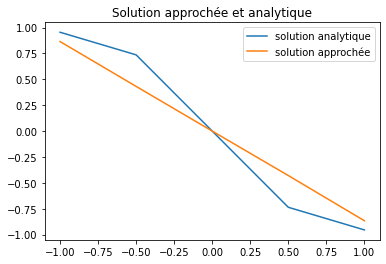

In [557]:
#solution trouvée
Y = [A + (X[i]-x0)*NN(X[i], w, b, v) for i in range(m)]

#solution analytique
K = (A-1) / (A+1)
Kexp = K*exp(2*lamb*W*X)
Z = (1+Kexp) / (1-Kexp)

plot(X,Z, label='solution analytique')
plot(X,Y, label='solution approchée')
legend()
title('Solution approchée et analytique')
show()